In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter_train_val_test

In [5]:
from DataSets import UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
DATA_DIR_IH = "/data/uob/"

In [8]:
data_dir = DATA_DIR_DEEPTHOUGHT

In [9]:
model_name = "../model/trained_cUNet_pytorch_regression_2_4_10_20_25_35_dataset_100epochs_coeff_mask0.75_validation.pkl"

In [10]:
model_inference = cUNet(out_size=1)

In [11]:
model_inference.load_state_dict(torch.load(model_name));

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
root_folder = os.path.join(data_dir, "dataset")

In [14]:
excluded = ["10x10_2mm_first_clean", "10x10_4mm_first_clean", "10x10_10mm_first_clean", "10x10_20mm_first_clean",
            '10x10_25mm_first_clean', '10x10_35mm_first_clean',
            "10x10_2mm_second_clean", "10x10_4mm_second_clean", "10x10_10mm_second_clean", "10x10_20mm_second_clean",
            "10x10_25mm_second_clean", "10x10_35mm_second_clean"
            '10x10_2mm_third_clean', '10x10_4mm_third_clean', "10x10_10mm_third_clean", '10x10_20mm_third_clean', 
           "10x10_25mm_third_clean", '10x10_35mm_third_clean']

In [15]:
composed = transforms.Compose([Cut(), Rescale(.25), ChannelsFirst(), ToTensor()])

In [16]:
dataset = UNetDatasetFromFolders(root_folder, excluded=excluded, transform=composed)

In [17]:
batch_size=16

In [18]:
data_loaders = DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [19]:
len(dataset)

4132

In [20]:
model_inference.eval()
model_inference.to(device);

batch 1
1: true_dist: 3, pred_dist: [3.3286288]


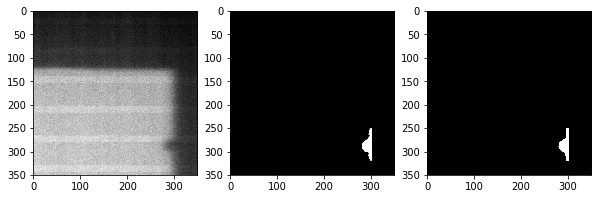

2: true_dist: 2, pred_dist: [1.9809978]


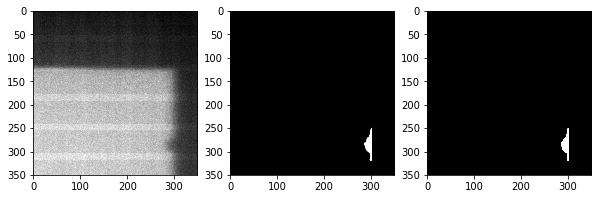

3: true_dist: 3, pred_dist: [3.3506987]


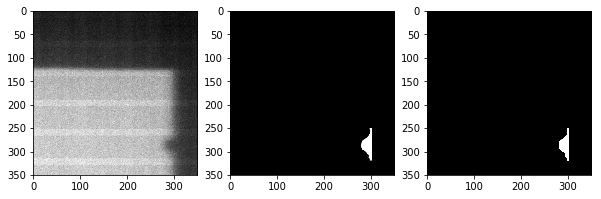

4: true_dist: 15, pred_dist: [14.773407]


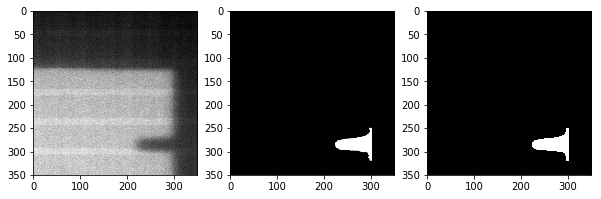

5: true_dist: 15, pred_dist: [14.783535]


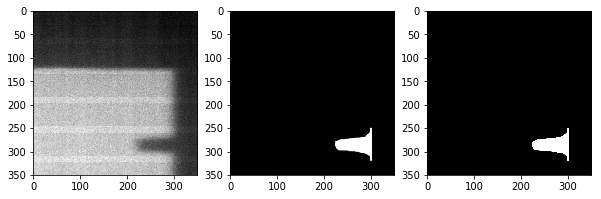

6: true_dist: 3, pred_dist: [3.2794037]


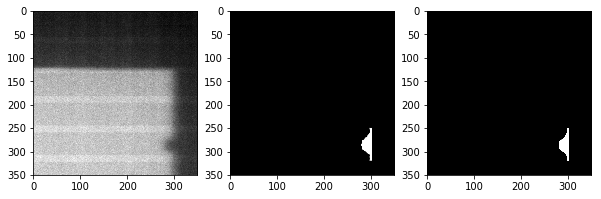

7: true_dist: 1, pred_dist: [1.7604418]


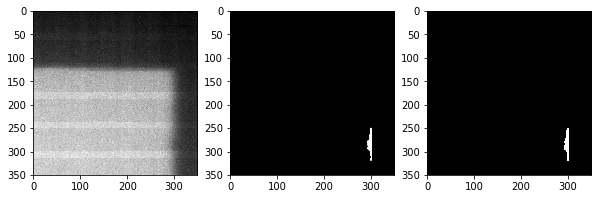

8: true_dist: 1, pred_dist: [1.7873725]


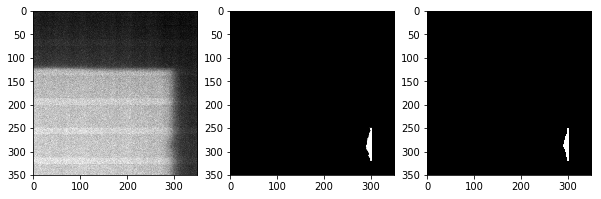

9: true_dist: 3, pred_dist: [2.8046308]


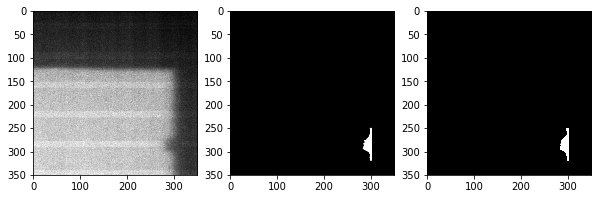

10: true_dist: 3, pred_dist: [3.3012526]


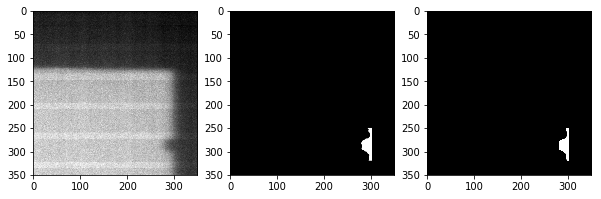

11: true_dist: 30, pred_dist: [30.91981]


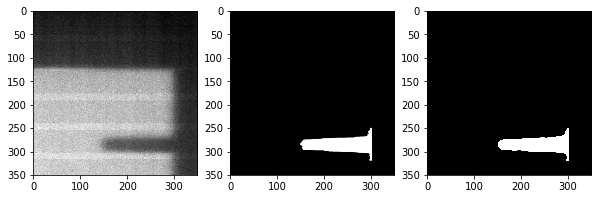

12: true_dist: 1, pred_dist: [1.826976]


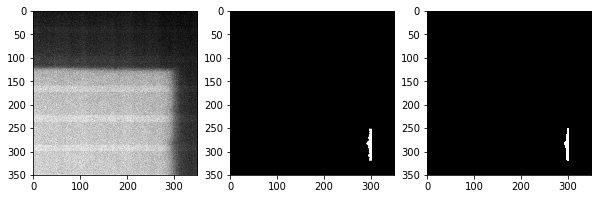

13: true_dist: 30, pred_dist: [30.946999]


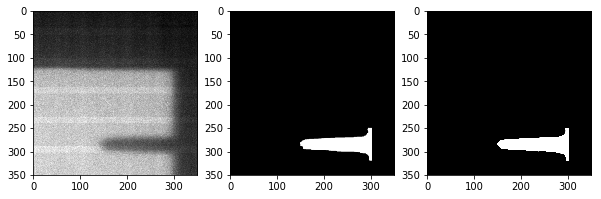

14: true_dist: 15, pred_dist: [14.675885]


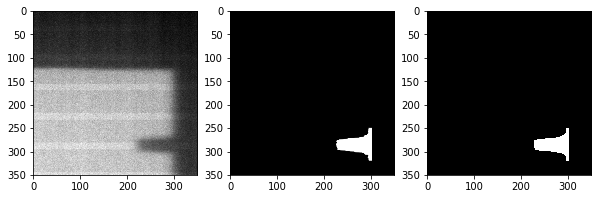

15: true_dist: 35, pred_dist: [34.963387]


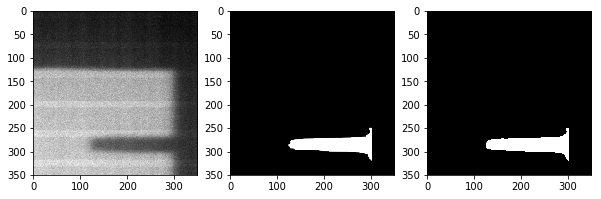

16: true_dist: 15, pred_dist: [14.7460375]


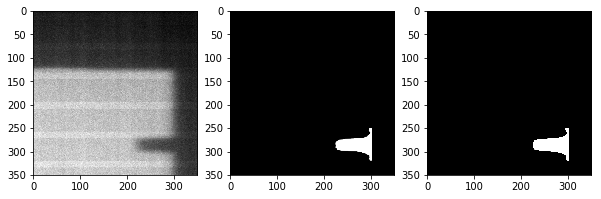

batch 2
1: true_dist: 3, pred_dist: [3.244889]


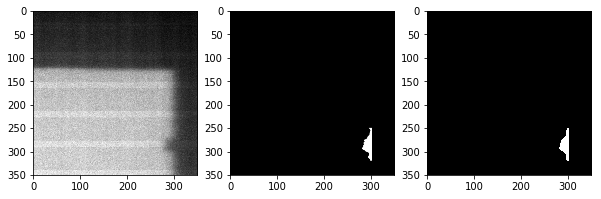

2: true_dist: 1, pred_dist: [1.8099343]


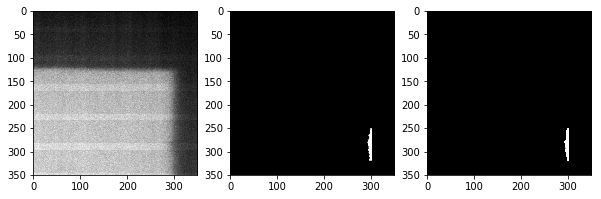

3: true_dist: 35, pred_dist: [35.01802]


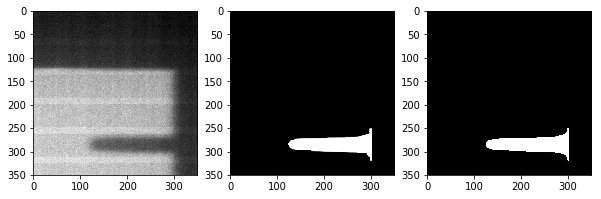

4: true_dist: 15, pred_dist: [14.709305]


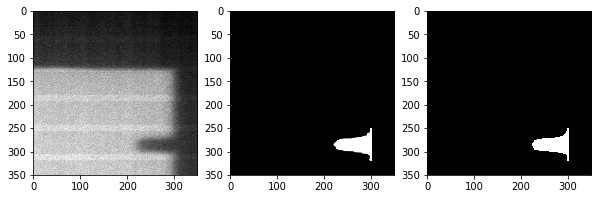

5: true_dist: 30, pred_dist: [31.00346]


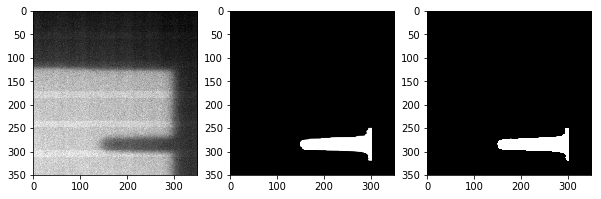

6: true_dist: 30, pred_dist: [30.901228]


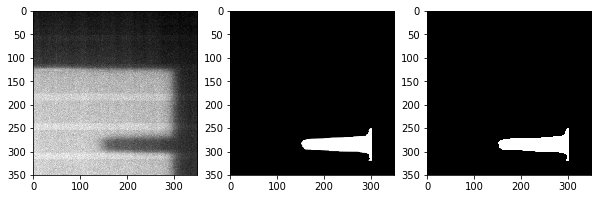

7: true_dist: 15, pred_dist: [14.759273]


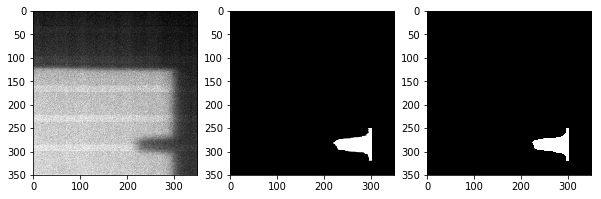

8: true_dist: 1, pred_dist: [1.80588]


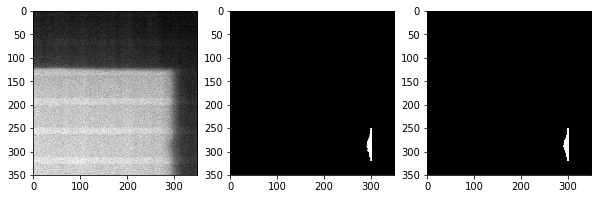

9: true_dist: 1, pred_dist: [1.7727232]


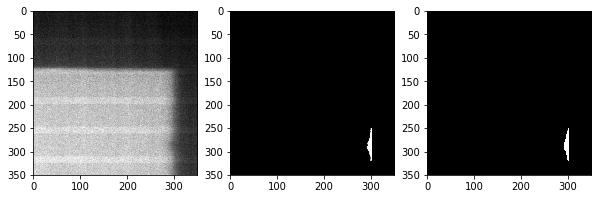

10: true_dist: 30, pred_dist: [30.92518]


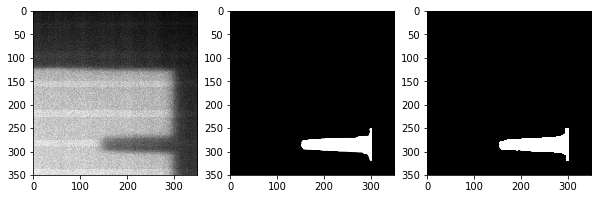

11: true_dist: 30, pred_dist: [30.91368]


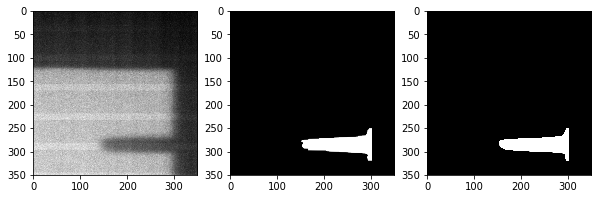

12: true_dist: 15, pred_dist: [14.734459]


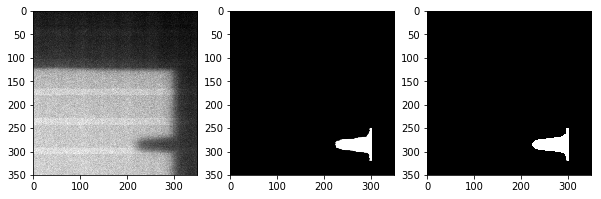

13: true_dist: 1, pred_dist: [1.771082]


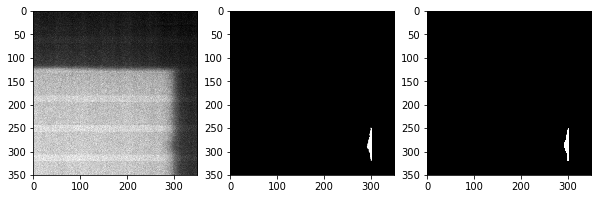

14: true_dist: 15, pred_dist: [14.698833]


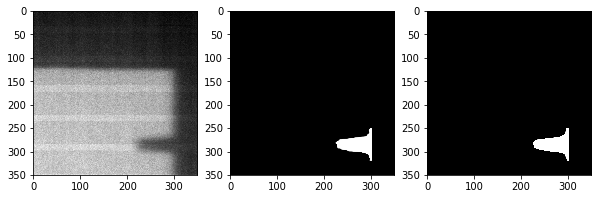

15: true_dist: 15, pred_dist: [14.7219]


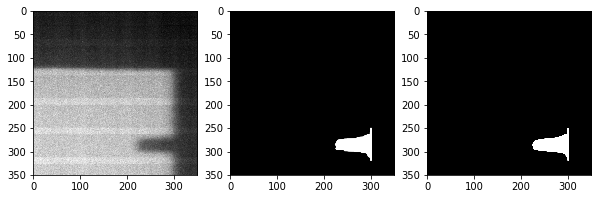

16: true_dist: 15, pred_dist: [14.755589]


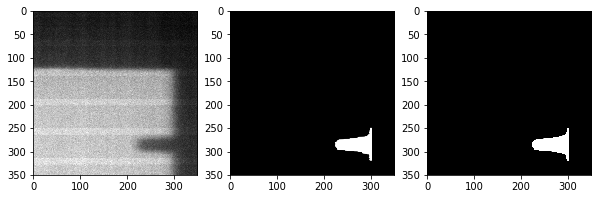

In [21]:
for i, batch in tqdm(enumerate(data_loaders), desc='Batch', total=len(dataset)//batch_size):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_dist, pr_msk, pr_dist) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
    
        true_dist = tr_dist
        pred_dist = pr_dist
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [21]:
y_true = []
y_pred = []

for i, batch in tqdm(enumerate(data_loaders), total = len(dataset)//batch_size, desc = "Mini Batch"):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)




In [22]:
y_pred = np.asarray(y_pred).ravel()
y_true = np.asarray(y_true)

print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 0.36257324219210607


In [23]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [24]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [25]:
idx_1, mse_1 = idx_mse(1)
#idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
#idx_4, mse_4 = idx_mse(4)
#idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
#idx_20, mse_20 = idx_mse(20)
#idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
#idx_35, mse_35 = idx_mse(35)

1 0.6138566612881259
3 0.09559289092657529
15 0.06890080914667124
30 0.8928092302817136


In [26]:
distances = [1,3,15,30]

In [27]:
errors = [idx_mse(i)[1] for i in distances]

1 0.6138566612881259
3 0.09559289092657529
15 0.06890080914667124
30 0.8928092302817136


(0, 1)

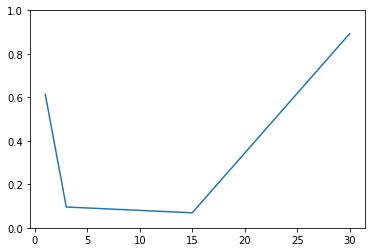

In [28]:
plt.plot(distances, errors)
plt.ylim((0,1))

In [29]:
np.savez_compressed("Predicted_train_6positions_100epochs.npz",
                   true = y_true, pred = y_pred)